In [1]:
include("ct_utils.jl")
using .CTUtils
using DataFrames
using CSV 
using PyPlot

In [2]:
df_ct = ct_to_df("../simulation_data/chargetransport/si-topcon-ill-sc.csv")
df_scaps = scaps_to_df("../simulation_data/scaps/si-topcon-ill-sc.eb")

Row,i,x(um),y,Ec(eV),Fn(eV),Fp(eV),Ev(eV),n(/cm3),p(/cm3),rho(defect) (/cm3),net doping (/cm3),rho(/cm3),E(V/cm),jn(mA/cm2),jp(mA/cm2),jn_tunnel(mA/cm2),jp_tunnel(mA/cm2),jtot(mA/cm2),generation(#/cm3.s),recombination(#/cm3.s),cumulative generation (mA/cm2),cumulative recombination L to R (mA/cm2),cumulative recombination R to L (mA/cm2)
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,0.0,0.0,1.10574,0.563833,-0.0,-0.0142591,2.2929e10,5.997e18,0.0,-5.997e18,-2.53035e11,-587.027,-0.00545194,-37.8614,1.83273e-28,0.0,-37.8669,6.81972e21,7.42736e17,0.0,-0.00545194,0.0214094
2,1.0,0.0001,0.0,1.10573,0.563833,-0.0,-0.014265,2.29342e10,5.99564e18,0.0,-5.99565e18,-5.28086e12,-587.035,-0.0109333,-37.8559,1.82077e-28,0.0,-37.8669,6.76964e21,7.42568e17,0.0108851,-0.00545075,0.0268601
3,2.0,0.000202,0.0,1.10573,0.563833,-0.0,-0.014271,2.29394e10,5.99425e18,0.0,-5.99426e18,-1.01201e13,-587.047,-0.0220924,-37.8448,1.79661e-28,0.0,-37.8669,6.71899e21,7.42395e17,0.0219266,-0.00544953,0.0268589
4,3.0,0.000311,0.0,1.10572,0.563833,-0.0,-0.0142774,2.2945e10,5.99277e18,0.0,-5.99279e18,-1.49607e13,-587.068,-0.0338849,-37.8329,1.77145e-28,0.0,-37.8668,6.66563e21,7.42211e17,0.0335933,-0.00544824,0.0268576
5,4.0,0.000431,0.0,1.10572,0.563833,-0.0,-0.0142845,2.29512e10,5.99114e18,0.0,-5.99116e18,-1.99591e13,-587.1,-0.046816,-37.82,1.74421e-28,0.0,-37.8668,6.60736e21,7.42006e17,0.0463791,-0.00544681,0.0268562
6,5.0,0.000569,0.0,1.10571,0.563833,-0.0,-0.0142925,2.29582e10,5.98928e18,0.0,-5.9893e18,-2.5248e13,-587.147,-0.0614593,-37.8054,1.7137e-28,0.0,-37.8668,6.54168e21,7.41771e17,0.0608451,-0.00544518,0.0268545
7,6.0,0.00073,0.0,1.1057,0.563833,-0.0,-0.014302,2.29665e10,5.98708e18,0.0,-5.98711e18,-3.09378e13,-587.216,-0.0785037,-37.7883,1.67851e-28,0.0,-37.8668,6.46565e21,7.41493e17,0.077665,-0.00544326,0.0268526
8,7.0,0.000925,0.0,1.10569,0.563832,-0.0,-0.0143134,2.29763e10,5.98444e18,0.0,-5.98448e18,-3.71083e13,-587.316,-0.098806,-37.7681,1.6369e-28,0.0,-37.8669,6.37569e21,7.41157e17,0.0976764,-0.00544095,0.0268503
9,8.0,0.001164,0.0,1.10567,0.563832,-0.0,-0.0143275,2.29883e10,5.98119e18,0.0,-5.98124e18,-4.37909e13,-587.464,-0.123454,-37.7434,1.58665e-28,0.0,-37.8668,6.26731e21,7.4074e17,0.121943,-0.0054381,0.0268475


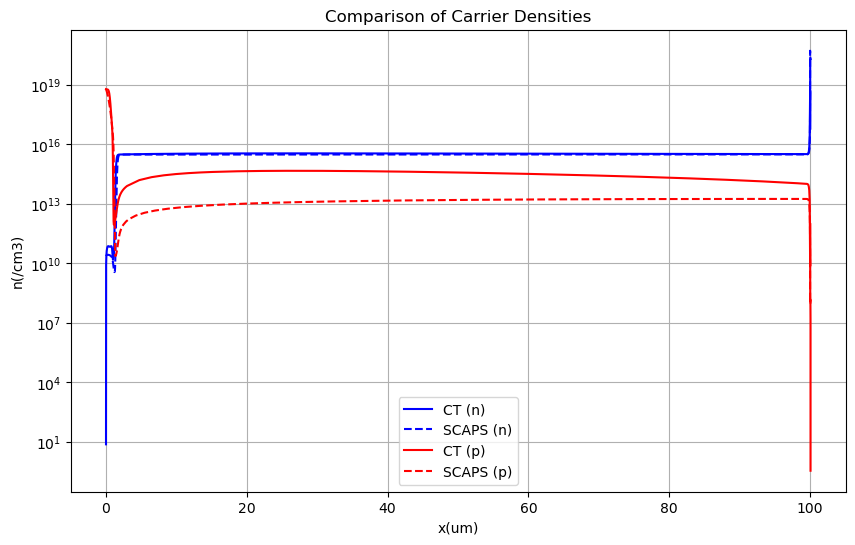

In [3]:
compare_densities(df_ct, df_scaps)
display(gcf())

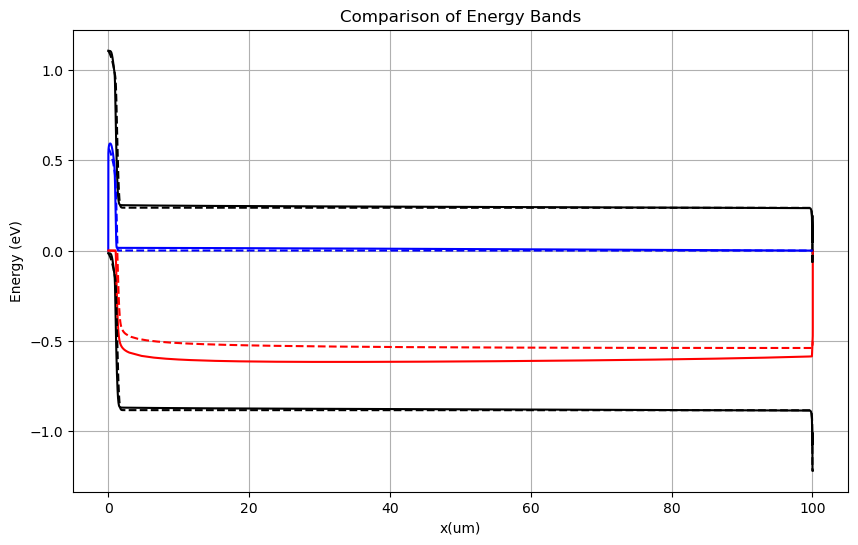

In [4]:
compare_bands(df_ct, df_scaps)
display(gcf())